1. Import Library

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve

import shap
import warnings
warnings.filterwarnings('ignore')

2. Load Data Credit Scoring

In [14]:
file_path = "../data/credit_scoring.csv"
data = pd.read_csv(file_path)


In [15]:
data.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


3. Drop Leakage Columns (leak_col_good atau leak_col_subtle )

In [16]:
data = data.drop(columns=["leak_col_good", "leak_col_subtle"])

In [30]:
data.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0


4. EDA

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   application_id     6000 non-null   int64
 1   age                6000 non-null   int64
 2   monthly_income     6000 non-null   int64
 3   loan_amount        6000 non-null   int64
 4   previous_defaults  6000 non-null   int64
 5   credit_score       6000 non-null   int64
 6   default            6000 non-null   int64
dtypes: int64(7)
memory usage: 328.3 KB


In [ ]:
data.describe()

       application_id          age  monthly_income   loan_amount  \
count     6000.000000  6000.000000    6.000000e+03  6.000000e+03   
mean    503999.500000    40.321500    1.140386e+07  8.001122e+06   
std       1732.195139    11.300697    4.912598e+06  4.071786e+06   
min     501000.000000    21.000000    3.000310e+06  1.000794e+06   
25%     502499.750000    31.000000    7.163379e+06  4.440939e+06   
50%     503999.500000    41.000000    1.129945e+07  7.982304e+06   
75%     505499.250000    50.000000    1.573705e+07  1.153144e+07   
max     506999.000000    59.000000    1.998622e+07  1.499858e+07   

       previous_defaults  credit_score      default  
count        6000.000000   6000.000000  6000.000000  
mean            0.243667    575.979833     0.012167  
std             0.484767    158.328931     0.109639  
min             0.000000    300.000000     0.000000  
25%             0.000000    438.750000     0.000000  
50%             0.000000    577.500000     0.000000  
75%      

In [32]:
data["default"].value_counts(normalize=True)

default
0    0.987833
1    0.012167
Name: proportion, dtype: float64

5. Preprocessing Data

In [ ]:
X = data.drop(columns=["default"])
y = data["default"]

numeric_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

6. Baseline Model - Logistic Regression

In [39]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]
y_pred_lr = model_lr.predict(X_test)

print("AUC Logistic Regression:", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, y_pred_lr))

AUC Logistic Regression: 0.770182841068917
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200



7. Gradient Boosting

In [24]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train, y_train)

y_pred_proba_gb = model_gb.predict_proba(X_test)[:, 1]
y_pred_gb = model_gb.predict(X_test)

print("AUC Gradient Boosting:", roc_auc_score(y_test, y_pred_proba_gb))
print(classification_report(y_test, y_pred_gb))

AUC Gradient Boosting: 0.7237412095639943
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.98      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.98      0.98      1200



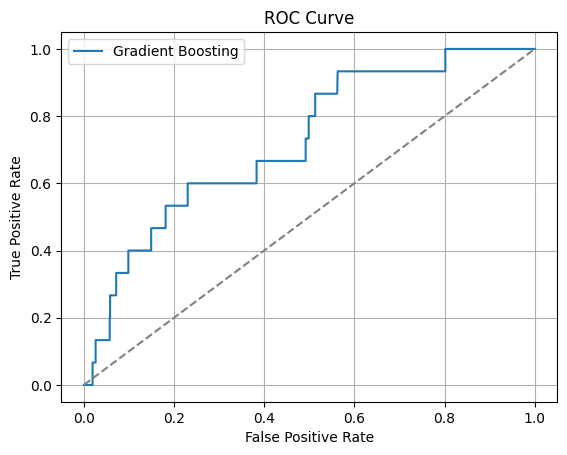

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gb)
plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

8. Fungsi scorecard(prob) → skala 300-850 (referensi industri) 

In [26]:
def scorecard(prob, min_score=300, max_score=850):
    return min_score + (max_score - min_score) * (1 - prob)

credit_scores = scorecard(y_pred_proba_gb)

In [27]:
data_scores = pd.DataFrame({
    'Probability': y_pred_proba_gb,
    'Credit Score': credit_scores
})

print(data_scores.head())

   Probability  Credit Score
0     0.001741    849.042319
1     0.004631    847.452896
2     0.000540    849.703192
3     0.002810    848.454600
4     0.004488    847.531867


9. Interpretasi SHAP

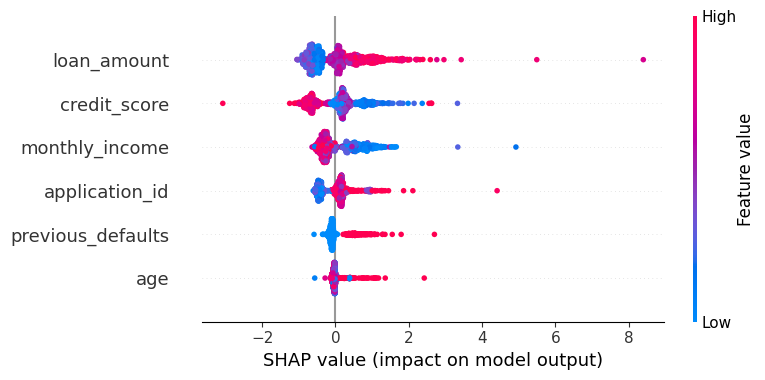

In [28]:
explainer = shap.Explainer(model_gb, X_test)
shap_values = explainer(X_test)

# Summary Plot - Top 10 Features
shap.summary_plot(shap_values, X_test, max_display=10, show=False)

plt.tight_layout()
plt.savefig("shap_top10.png")